<h1 style="text-decoration :underline;color:red">Prédiction du vainqueur :</h1>

<p style="color:blue">Le but de ce notebook est de déterminer le vainqueur entre le favori et le challenger ainsi que la probabilité de victoire de chacun des joueurs. Ensuite on cherchera à déterminer l'écart significatif entre nos probabilités de victoires et celles des bookmakers pour parier sur les bons matchs afin d'obtenir le meilleur gain, ROI.</p>

<h2 style="text-decoration :underline;color:green">Module utilisé lors de ce notebook :</h2>

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score,balanced_accuracy_score,make_scorer
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix,confusion_matrix,classification_report

pd.set_option('max_columns', 40)

<h2 style="text-decoration :underline;color:green">lecture du fichier:</h2>

In [53]:

df = pd.read_csv("data_clean_all.csv",index_col=0)

<h2 style="text-decoration :underline;color:green">Features à nettoyer:</h2>

<h3> Features qui seront supprimées

<li><b>Tournament

In [54]:
#la feature Tournament comporte beaucoup de modalités (170) et n'apparait pas pertinente pour notre modèle.
df.Tournament.value_counts()

Australian Open                  1424
Wimbledon                        1374
US Open                          1355
French Open                      1351
Sony Ericsson Open                791
                                 ... 
Vietnam Open                       21
Antalya Open                       21
CAM Open Comunidad Valenciana      21
Orange Prokom Open                 21
Tata Open                          20
Name: Tournament, Length: 170, dtype: int64

<li><b>Location

In [55]:
#la feature Location comporte beaucoup de modalités (101) et n'apparait pas pertinente pour notre modèle.
df.Location.value_counts()

Paris              1882
London             1479
Melbourne          1424
New York           1378
Indian Wells       1066
                   ... 
Oeiras               23
Ho Chi Min City      21
Antalya              21
Warsaw               21
Pune                 20
Name: Location, Length: 101, dtype: int64

<li><b>Round

In [56]:
#la feature Round comporte 8 modalités
df.Round.value_counts()

1st Round        11921
2nd Round         8700
Quarterfinals     3028
3rd Round         2229
Semifinals        1538
The Final          781
4th Round          558
Round Robin        235
Name: Round, dtype: int64

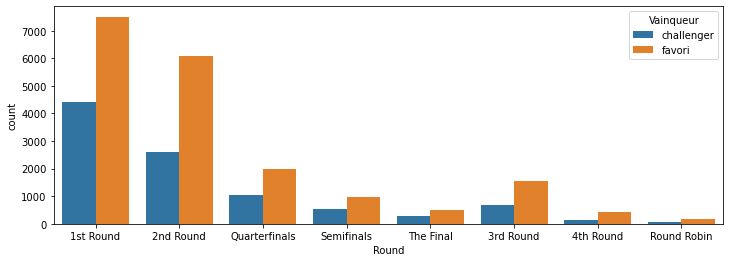

In [57]:
plt.figure(figsize=(12,4))
sns.countplot(x='Round',data=df,hue="Vainqueur");
#on remarque que cette feature n'influence pas la target, on observe toujours 2 fois plus de victoire favori que challenger.

<li><b>Comment

In [58]:
#on a supprimé les quelques valeurs manquantes et il ne reste qu'une seule modalité.
df.Comment.value_counts()

Completed    28990
Name: Comment, dtype: int64

<li>Favori et Challenger
<p> Beaucoup trop de modalités dans ces features pour qu'elles soient pertinentes, même si quelques joueurs Nadal, Federer, Djokovic sortent du lot, on cherche à se baser sur les performances du joueur et non le joueur lui-même.</p>
    

<li><b>Date</b>
<p>La date n'influe pas sur le score des matchs mais elle a permis de calculer de nouvelles features sur l'historique des performances des joueurs.

<li><b> Series

In [59]:
df.Series.value_counts()

ATP250                6994
Grand Slam            5504
International         5437
Masters 1000          3695
ATP500                2796
Masters               2695
International Gold    1694
Masters Cup            175
Name: Series, dtype: int64

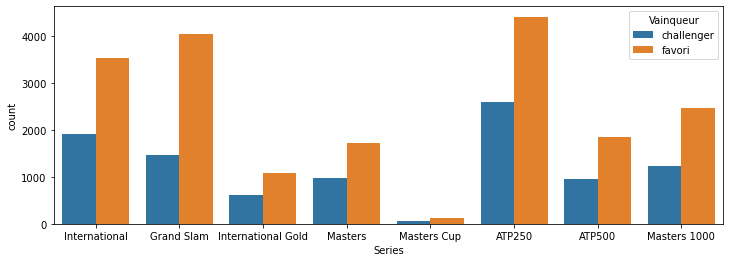

In [60]:
plt.figure(figsize=(12,4))
sns.countplot(x='Series',data=df,hue="Vainqueur");
#le ratio de victoire est similaire entre favori et challenger quelque soit la serie

<li><b>ATP</b>
<p> Feature obscure comportant beaucoup trop de modalités pour être pertinente.

In [61]:
df.ATP.value_counts()

6     1424
19    1071
20     981
51     890
31     820
      ... 
4      282
22     277
8      276
66     219
67      56
Name: ATP, Length: 67, dtype: int64

<li><b>Winner, Wsets et Lsets</b>
<p> Ces features ne sont pas connues avant le match !!!
    

<li><b>Features des bookmakers</b>
<p> On enlève les cotes des bookmaker pour ne pas être biaisé par leur propre prédiction. Le but est de battre leur cote justement.

In [62]:
#on enlève les variables non pertinentes pour l'algo

df= df.drop(["Favori","Challenger","Comment","Tournament","Round","Location","Date","Series","ATP","Winner","Wsets","Lsets","B365_F","B365_C"],axis=1)
df = df.reset_index().drop("index",axis=1)

In [63]:
df

,Rank_F,PS_F,elo_F,proba_elo_F,TV_F,TV_surf_F,sets_F,Rank_C,PS_C,elo_C,proba_elo_C,TV_C,TV_surf_C,sets_C,Court,Surface,Best of,Vainqueur,moy_elo_F,moy_elo_C
0,58,1.719,1618.182210,0.681306,0.500000,0.500000,0.0,246,2.21,1486.195239,0.318694,0.428571,0.500000,0.0,Outdoor,Hard,3,challenger,-36.522332,-20.871951
1,6,1.385,1820.759485,0.765687,0.763158,0.720000,0.0,43,3.25,1615.057648,0.234313,0.461538,0.428571,0.0,Outdoor,Hard,3,challenger,19.791315,41.588209
2,39,1.746,1654.468551,0.594046,0.666667,0.600000,0.0,67,2.18,1588.330984,0.405954,0.571429,0.555556,0.0,Outdoor,Hard,3,favori,15.865896,40.962208
3,52,2.060,1584.479208,0.522221,0.571429,0.500000,0.0,96,1.82,1569.027967,0.477779,0.461538,0.454545,0.0,Outdoor,Hard,3,favori,-4.357656,34.077361
4,92,1.455,1452.260713,0.440959,0.444444,0.333333,0.0,99,2.90,1493.478855,0.559041,0.666667,0.000000,0.0,Outdoor,Hard,3,favori,-61.224824,-10.241221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28985,15,2.430,1842.459807,0.509437,0.772727,0.772727,11.0,23,1.65,1835.901543,0.490563,0.631579,0.631579,9.0,Outdoor,Hard,3,challenger,48.408738,165.883261
28986,8,1.340,1843.576914,0.755103,0.611111,0.611111,6.0,59,3.63,1647.967561,0.244897,0.428571,0.428571,4.0,Outdoor,Hard,3,favori,29.784931,46.204092
28987,69,2.090,1619.758421,0.545159,0.500000,0.571429,9.0,73,1.85,1588.293069,0.454841,0.692308,0.800000,9.0,Indoor,Clay,3,challenger,-61.940388,79.942472
28988,8,2.750,1851.413609,0.340138,0.666667,0.666667,9.0,9,1.52,1966.532849,0.659862,0.800000,0.800000,9.0,Outdoor,Hard,3,challenger,39.699484,220.827893


<hr>
<h2 style="text-decoration :underline;color:green">Séparation feature et target</h2>

In [64]:
target = df.Vainqueur

In [65]:
#on enlève les cotes des bookmaker pour ne pas être biaisé par leur valeur.
data =  df.drop(["Vainqueur","PS_C","PS_F"],axis=1)


<hr>
<h2 style="text-decoration :underline;color:green">Normalisation des données </h2>

<h3 style="text-decoration :underline;color:blue">Variables catégorielles </h3>

In [66]:
#transformation en variables indicatrices
cat = data.loc[:,data.dtypes==np.object]
cat = pd.get_dummies(cat,drop_first=True)


In [67]:
bestof = pd.get_dummies(df['Best of'],prefix='Best_of',drop_first=True)


In [68]:
categorical = cat.join(bestof)


In [69]:
categorical

,Court_Outdoor,Surface_Clay,Surface_Grass,Surface_Hard,Best_of_5
0,1,0,0,1,0
1,1,0,0,1,0
2,1,0,0,1,0
3,1,0,0,1,0
4,1,0,0,1,0
...,...,...,...,...,...
28985,1,0,0,1,0
28986,1,0,0,1,0
28987,0,1,0,0,0
28988,1,0,0,1,0


<h3 style="text-decoration :underline;color:blue">Variables numériques </h3>

In [70]:
#normalisation
num= data.select_dtypes(include='number')
num = num.drop("Best of", axis=1)
scaler = MinMaxScaler()
num_scaled = pd.DataFrame(scaler.fit_transform(num), columns = num.columns)
num_scaled.shape

(28990, 14)

<h3 style="text-decoration :underline;color:blue">Features finales </h3>

In [72]:
#jonction des variables numériques et  catégorielles
data = num_scaled.join(categorical)

data

,Rank_F,elo_F,proba_elo_F,TV_F,TV_surf_F,sets_F,Rank_C,elo_C,proba_elo_C,TV_C,TV_surf_C,sets_C,moy_elo_F,moy_elo_C,Court_Outdoor,Surface_Clay,Surface_Grass,Surface_Hard,Best_of_5
0,0.059548,0.271326,0.669519,0.500000,0.500000,0.000000,0.129237,0.163230,0.330481,0.428571,0.500000,0.000000,0.729413,0.295515,1,0,0,1,0
1,0.006160,0.461984,0.758246,0.763158,0.720000,0.000000,0.021716,0.292835,0.241754,0.461538,0.428571,0.000000,0.779021,0.376405,1,0,0,1,0
2,0.040041,0.305477,0.577766,0.666667,0.600000,0.000000,0.034428,0.265955,0.422234,0.571429,0.555556,0.000000,0.775563,0.375594,1,0,0,1,0
3,0.053388,0.239606,0.502243,0.571429,0.500000,0.000000,0.049788,0.246540,0.497757,0.461538,0.454545,0.000000,0.757747,0.366678,1,0,0,1,0
4,0.094456,0.115166,0.416796,0.444444,0.333333,0.000000,0.051377,0.170555,0.583204,0.666667,0.000000,0.000000,0.707651,0.309282,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28985,0.015400,0.482408,0.488800,0.772727,0.772727,0.500000,0.011123,0.514953,0.511200,0.631579,0.631579,0.333333,0.804231,0.537375,1,0,0,1,0
28986,0.008214,0.483459,0.747117,0.611111,0.611111,0.272727,0.030191,0.325935,0.252883,0.428571,0.428571,0.148148,0.787825,0.382382,1,0,0,1,0
28987,0.070842,0.272809,0.526361,0.500000,0.571429,0.409091,0.037606,0.265916,0.473639,0.692308,0.800000,0.333333,0.707021,0.426076,0,1,0,0,0
28988,0.008214,0.490835,0.310783,0.666667,0.666667,0.409091,0.003708,0.646338,0.689217,0.800000,0.800000,0.333333,0.796559,0.608532,1,0,0,1,0


<hr>
<h2 style="text-decoration :underline;color:green">Séparation set entrainement et set test </h2>

In [73]:
X_train,X_test,y_train,y_test = train_test_split(data,target,shuffle=False,test_size=0.2,random_state=1000)

<hr>
<h2 style="text-decoration :underline;color:green">Développement des algo avec Grid des meilleurs hyperparamètres pour chaque algo </h2>

In [74]:
#fonction qui fournit pour un modele donné, après double validation croisée, l'accuracy du modèle, son écart type, le résultat obtenu avec les meilleurs paramètres.
def Grid(clf, param):
    outer_cv = StratifiedKFold(n_splits = 5, shuffle=True)
    grid_clf = GridSearchCV(estimator=clf,param_grid = param,n_jobs=-1)
    grid_clf.fit(X_train,y_train)
    score = cross_val_score(grid_clf,X_train,y_train,cv = outer_cv)
    print("accuracy du modèle : ", score.mean())
    print("ecart type du modèle : ", score.std())
    
    print("meilleur paramètre : ", grid_clf.best_params_)
    print("score train : ",round(100*grid_clf.score(X_train,y_train),2))
    print("score test : ", round(100*grid_clf.score(X_test,y_test),2))
    
    #récupération des probabilités de victoires
    y_pr =grid_clf.predict(data)
    predict = pd.DataFrame(y_pr,index=data.index ,columns=["Prediction"])
    y_pred = grid_clf.predict_proba(data)
    proba = pd.DataFrame(y_pred,index=data.index ,columns=["Proba_Challenger","Proba_Favori"])
    
    plot_confusion_matrix(grid_clf,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["Challenger","Favori"])
    
    predictions =grid_clf.predict(X_test)
    print(classification_report(y_test,predictions))
    #création du dataframe pari associé à l'algo
    pari = df_pari
    #ajout de la prédiction
    pari = pari.join(predict)
    #ajout des proba de prediction
    pari = pari.join(proba)
    #export du fichier pari pour éviter de relancer l'algo à chaque fois
    pari.to_csv("pari"+str(clf)+".csv")
    


<h3 style="text-decoration :underline;color:blue">Définition de différents paramètres possibles pour chaque algo  </h3>

<li>Régression logistique

In [75]:
param_lr = {'solver':['liblinear','lbfgs'],'C':np.logspace(-4,2,9)}
clf_lr = LogisticRegression(max_iter= 2000)

<li>Random forest

In [76]:
param_rf = [{'n_estimators':[10,50,100,250,500,1000],
             'min_samples_leaf':[1,2,5],
             'max_features':['sqrt','log2']}]
clf_rf = RandomForestClassifier(n_jobs = -1)

<li>Arbre de décision

In [77]:
param_dtc = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
clf_dtc = DecisionTreeClassifier()

<li>K plus proches voisins

In [78]:
param_knn = {'n_neighbors': [3,5,11,19],'weights':['uniform','distance'],'metric':['euclidean','manhattan','minkowski']}
clf_knn = neighbors.KNeighborsClassifier()

<h3 style="text-decoration :underline;color:blue">Résultat avec les meilleurs hyperparamètres obtenus  </h3>

<li>LogisticRegression

accuracy du modèle :  0.6763542331588652
ecart type du modèle :  0.003684684609389298
meilleur paramètre :  {'C': 0.5623413251903491, 'solver': 'liblinear'}
score train :  67.8
score test :  67.59
              precision    recall  f1-score   support

  challenger       0.53      0.20      0.29      1922
      favori       0.70      0.91      0.79      3876

    accuracy                           0.68      5798
   macro avg       0.61      0.56      0.54      5798
weighted avg       0.64      0.68      0.63      5798



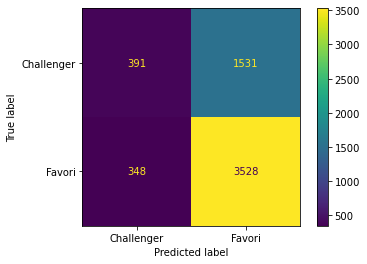

In [27]:
Grid(clf_lr,param_lr)

<li>RandomForest

accuracy du modèle :  0.6748451106499902
ecart type du modèle :  0.005626034931714589
meilleur paramètre :  {'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 500}
score train :  91.41
score test :  67.07
              precision    recall  f1-score   support

  challenger       0.51      0.25      0.33      1922
      favori       0.70      0.88      0.78      3876

    accuracy                           0.67      5798
   macro avg       0.60      0.56      0.56      5798
weighted avg       0.64      0.67      0.63      5798



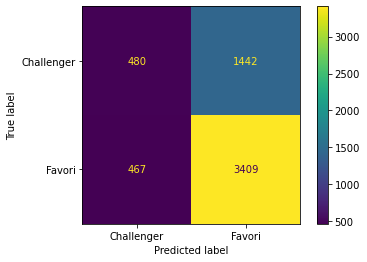

In [28]:
Grid(clf_rf,param_rf)

<li>Decision Tree

accuracy du modèle :  0.6776903841579366
ecart type du modèle :  0.004879613774457636
meilleur paramètre :  {'criterion': 'entropy', 'max_depth': 4}
score train :  68.01
score test :  67.73
              precision    recall  f1-score   support

  challenger       0.53      0.22      0.31      1922
      favori       0.70      0.91      0.79      3876

    accuracy                           0.68      5798
   macro avg       0.62      0.56      0.55      5798
weighted avg       0.64      0.68      0.63      5798



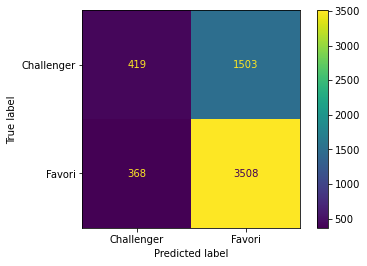

In [29]:
Grid(clf_dtc,param_dtc)

<li>Plus proche voisins

accuracy du modèle :  0.6645823636917482
ecart type du modèle :  0.003423367287410201
meilleur paramètre :  {'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'uniform'}
score train :  70.12
score test :  66.13
              precision    recall  f1-score   support

  challenger       0.48      0.26      0.34      1922
      favori       0.70      0.86      0.77      3876

    accuracy                           0.66      5798
   macro avg       0.59      0.56      0.55      5798
weighted avg       0.63      0.66      0.63      5798



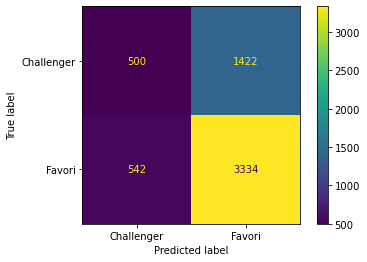

In [30]:
Grid(clf_knn,param_knn) 

<hr>
<h2 style="text-decoration :underline;color:green">Première itération avec XGBoost </h2>

In [79]:
clf_xgb = XGBClassifier(objective='binary:logistic')
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.78849
[1]	validation_0-aucpr:0.79225
[2]	validation_0-aucpr:0.79406
[3]	validation_0-aucpr:0.79646
[4]	validation_0-aucpr:0.79573
[5]	validation_0-aucpr:0.79607
[6]	validation_0-aucpr:0.79564
[7]	validation_0-aucpr:0.79518
[8]	validation_0-aucpr:0.79651
[9]	validation_0-aucpr:0.79569
[10]	validation_0-aucpr:0.79556
[11]	validation_0-aucpr:0.79424
[12]	validation_0-aucpr:0.79429
[13]	validation_0-aucpr:0.79426


C:\Users\Anthony\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14]	validation_0-aucpr:0.79516
[15]	validation_0-aucpr:0.79526
[16]	validation_0-aucpr:0.79495
[17]	validation_0-aucpr:0.79475


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

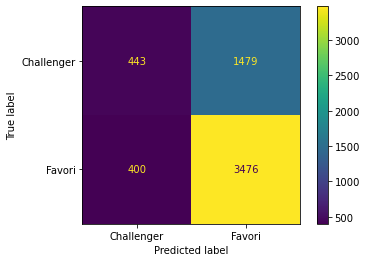

In [80]:
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["Challenger","Favori"])

In [81]:
predictions = clf_xgb.predict(X_test)

In [82]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

  challenger       0.53      0.23      0.32      1922
      favori       0.70      0.90      0.79      3876

    accuracy                           0.68      5798
   macro avg       0.61      0.56      0.55      5798
weighted avg       0.64      0.68      0.63      5798



<hr>
<h2 style="text-decoration :underline;color:green">Amélioration des résultats XGBoost avec la validation croisée </h2>

In [83]:
# parametre pour XGBoost
params = {
        'min_child_weight': list(np.arange(1,10,1)),
        'gamma': list(np.arange(0.5,5,0.5)),
        'subsample': list(np.arange(0.5,1,0.1)),
        'colsample_bytree': list(np.arange(0.5,1,0.1)),
        'max_depth': list(np.arange(3,5,1))
        }

In [84]:
#création du classifieur
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [85]:
#validation croisée + recherche des meilleurs hyperparametres avec randomized
folds = 30
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

random_search.fit(X_train, y_train)

Fitting 30 folds for each of 5 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  5.9min finished
C:\Users\Anthony\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:57:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:57:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x00000155AD5C9EB0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.02,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, mis...
                                           validate_parameters=None,
                                           verbosity=None),
                   n_iter=5, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7,
                     

In [86]:
random_search.score(X_test,y_test)

0.6752171102298195

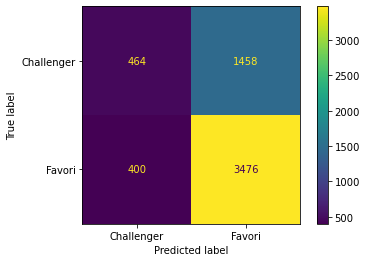

In [87]:
plot_confusion_matrix(random_search,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["Challenger","Favori"])

In [88]:
#récupération des probabilités de victoires
y_pr = random_search.predict(data)
predict =  pd.DataFrame(y_pr,index=data.index ,columns=["Prediction"])
y_pred = random_search.predict_proba(data)
proba = pd.DataFrame(y_pred,index=data.index ,columns=["Proba_Challenger","Proba_Favori"])

<AxesSubplot:>

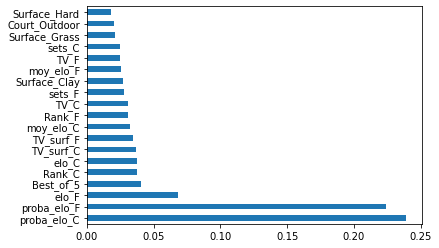

In [89]:
feat= pd.Series(random_search.best_estimator_.feature_importances_,index=X_train.columns)
feat.nlargest(20).plot(kind='barh')

In [90]:
predictions=random_search.predict(X_test)

In [92]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

  challenger       0.54      0.24      0.33      1922
      favori       0.70      0.90      0.79      3876

    accuracy                           0.68      5798
   macro avg       0.62      0.57      0.56      5798
weighted avg       0.65      0.68      0.64      5798



<h3 style="text-decoration :underline;color:blue">Sauvegarde du dataframe pari  </h3>

In [93]:
#création du dataframe pari
pari = df[["PS_C","PS_F","Vainqueur"]]

#ajout de la prédiction
pari = pari.join(predict)

#ajout des proba de prediction
pari = pari.join(proba)

#export du fichier pari pour éviter de relancer l'algo xgboost (qui est long) à chaque fois
pari.to_csv("pariXGBoost.csv")

<hr>
<h2 style="text-decoration :underline;color:green">Création d'un dataframe pari pour étudier les écarts entre les probabilités algo et bookmaker </h2>

<p style="color:blue">D'après notre étude préliminiaire du dataset, nous avons remarqué que le bookmaker Pinnacle est beaucoup plus généreux que Bet365 avec un ROI de -2% pour Pinnacle contre -6.5% pour Bet365. On prendra uniquement les cotes de Pinnacle pour la suite de notre étude.</p>

<h2> Choix de l'algo pour le ROI </h2>

In [94]:
#lecture du fichier pari
pari = pd.read_csv("pariXGBoost.csv",index_col=0)
#pari = pd.read_csv("pariLogisticRegression(max_iter=2000).csv",index_col=0)
#pari = pd.read_csv("pariDecisionTreeClassifier().csv",index_col=0)
#pari = pd.read_csv("pariRandomForestClassifier(n_jobs=-1).csv",index_col=0)
#pari = pd.read_csv("pariKNeighborsClassifier().csv",index_col=0)


In [96]:
#ajout de l'indice de confiance sur la cote
pari["proba_PS_Challenger"]=1/pari.PS_C
pari["proba_PS_Favori"]=1/pari.PS_F

pari["gain_theoriq_F"] = pari.Proba_Favori*pari.PS_F
pari["gain_theoriq_C"] =  pari.Proba_Challenger*pari.PS_C

pari["gain_confiance"]="wait"

for i in range(len(pari)):
    if pari["Prediction"][i]== "favori":
        pari["gain_confiance"][i]= pari["gain_theoriq_F"][i]
    else:
        pari["gain_confiance"][i]= pari["gain_theoriq_C"][i]

<ipython-input-96-06badfe1e5cb>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pari["gain_confiance"][i]= pari["gain_theoriq_F"][i]
<ipython-input-96-06badfe1e5cb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pari["gain_confiance"][i]= pari["gain_theoriq_C"][i]


In [97]:
#détermination de victoire du pari
pari["pari gagné"]=2
for i in range(len(pari)):
    if pari.Vainqueur[i] == pari.Prediction[i]:
        pari["pari gagné"][i]=1
    else:
        pari["pari gagné"][i]=0

#choix de la cote en fonction de la prediction
pari["cote"]=1.1
for i in range(len(pari)): 
    if pari.Prediction[i]=="favori":
        pari.cote[i] = pari.PS_F[i]
    else:
        pari.cote[i] = pari.PS_C[i]

#rangement en fonction de l'indice de confiance        
pari.sort_values(by = 'gain_confiance', ascending = False, inplace = True)

<ipython-input-97-f8aa0124b89c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pari["pari gagné"][i]=0
<ipython-input-97-f8aa0124b89c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pari["pari gagné"][i]=1
<ipython-input-97-f8aa0124b89c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pari.cote[i] = pari.PS_F[i]
<ipython-input-97-f8aa0124b89c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

<hr>
<h2 style="text-decoration :underline;color:green">Calcul du gain et du ROI en fonction du nombre de match </h2>

In [98]:
#création d'un dataframe test pour pouvoir tester plusieurs parametres essentiellement les cotes ici par exemple
test = pari
#test= test[test.Prediction == test.choix]
#on les range par indice décroissant
test.sort_values(by = 'gain_confiance', ascending = False, inplace = True)

test = test.reset_index().drop("index",axis=1)

In [99]:
test.to_csv("test.csv")

In [100]:
test.head(50)

,PS_C,PS_F,Vainqueur,Prediction,Proba_Challenger,Proba_Favori,proba_PS_Challenger,proba_PS_Favori,gain_theoriq_F,gain_theoriq_C,gain_confiance,pari gagné,cote
0,1.090,9.550,challenger,favori,0.440924,0.559076,0.917431,0.104712,5.339172,0.480608,5.33917,0,9.55
1,1.126,8.150,challenger,favori,0.456733,0.543267,0.888099,0.122699,4.427625,0.514281,4.42763,0,8.15
2,8.080,1.120,favori,challenger,0.537526,0.462474,0.123762,0.892857,0.517971,4.343209,4.34321,0,8.08
3,1.232,4.910,challenger,favori,0.144678,0.855322,0.811688,0.203666,4.199632,0.178243,4.19963,0,4.91
4,1.156,6.800,challenger,favori,0.399994,0.600006,0.865052,0.147059,4.080043,0.462393,4.08004,0,6.80
5,1.232,4.910,challenger,favori,0.187375,0.812625,0.811688,0.203666,3.989991,0.230845,3.98999,0,4.91
6,1.171,6.350,challenger,favori,0.378506,0.621494,0.853971,0.157480,3.946485,0.443231,3.94649,0,6.35
7,1.160,6.700,challenger,favori,0.457078,0.542922,0.862069,0.149254,3.637580,0.530210,3.63758,0,6.70
8,1.162,6.590,challenger,favori,0.451052,0.548948,0.860585,0.151745,3.617569,0.524122,3.61757,0,6.59
9,1.150,6.160,challenger,favori,0.414248,0.585752,0.869565,0.162338,3.608233,0.476385,3.60823,0,6.16


In [101]:
#fonction calculant le gain pour n match pariés
def gain(n):
    gain = 0.1
    argent = 0.1
    gain_roi = []
    mise_totale = 0
    for i in range(n):
        mise = 1
        if test["pari gagné"][i] == 1:
                argent += mise * test.loc[i,"cote"] -1
        else:
                argent -= mise
    #print(f"pour {n} matchs, vous avez gagné {round(argent,2)} et le rendement est de {ROI}% ")
    return argent

#fonction calculant le ROI pour n match (c'est la meme fonction qu'au dessus mais je n'arrive pas à récupérer séparemment les valeurs du tuple ensuite)
def Rent(n):
    gain = 0.1
    argent = 0.1
    gain_roi = []
    mise_totale = 0
    for i in range(n):
        mise = 1
        if test["pari gagné"][i] == 1:
                gain += mise * test["cote"][i]
                argent += mise * test.loc[i,"cote"] -1
        else:
                argent -= mise
                gain += 0
        mise_totale += mise
    ROI = (gain -  n)/ n + 1 
    #print(f"pour {n} matchs, vous avez gagné {round(argent,2)} et le rendement est de {ROI}% ")
    return ROI

In [102]:
#création d'une liste de  gain en fonction du nombre de match parié
nombre_de_paris = np.linspace(1,len(test),50,dtype=int)
gain_pari = []
ROI=[]
for i in nombre_de_paris:
    gain_pari.append(gain(i))
    ROI.append(Rent(i))    

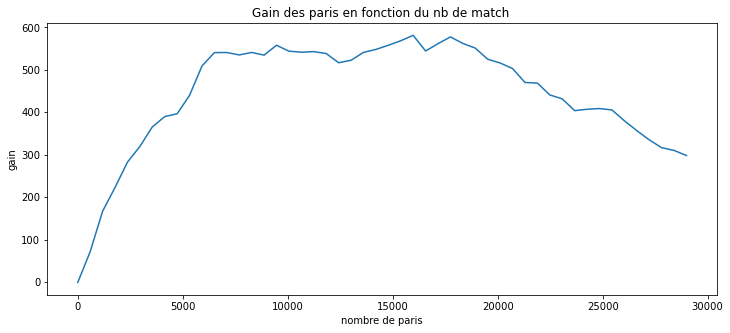

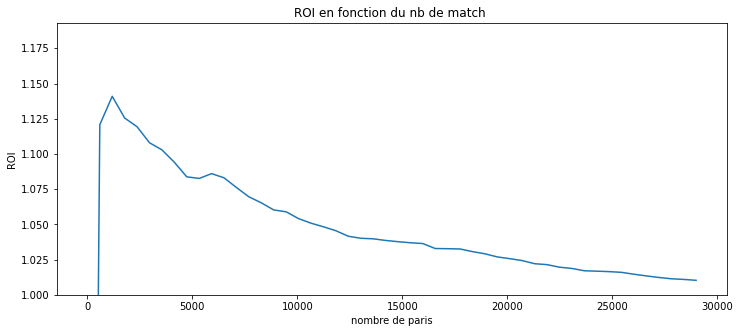

In [103]:
#affichage des gains en fonction du nombre de match pariés
plt.figure(figsize=(12,5))
plt.plot(nombre_de_paris, gain_pari)
plt.xlabel('nombre de paris')
plt.ylabel('gain');
plt.title(f"Gain des paris en fonction du nb de match ")
plt.show()

#affichage des gains en fonction du nombre de match pariés
plt.figure(figsize=(12,5))
plt.plot(nombre_de_paris, ROI)
plt.xlabel('nombre de paris')
plt.ylabel('ROI');
plt.title(f"ROI en fonction du nb de match ")
plt.ylim(1)
plt.show()
